Initialize

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ["KERAS_BACKEND"] = "torch"   # Must be called before importing keras
import keras
import torch
from scipy import stats
import warnings

warnings.filterwarnings("ignore")
seed = 100

# # Create requirements file (need to streamline)
# pip list -format-freeze > requirements.txt

In [12]:
# # Testing GPU access
# ## Using pytorch because jax won't work with cuda on Windows 11, and the tensorflow installation didn't recognize the gpu
# ## However, pytorch is MUCH slower when all use the GPU.
# print("Is CUDA available:", torch.cuda.is_available())
# print("Current device:", torch.cuda.get_device_name(0))

Import data and concatenate

In [13]:
outs = pl.read_excel("Data/Outcomes/outcomes.xlsx")
preds = pl.read_csv("Data/Predictors/Sleep(1).csv")
for i in range(9):
    temp = pl.read_csv(f"Data/Predictors/Sleep({i + 2}).csv")
    preds = pl.concat([preds, temp], how = "vertical")
preds = preds.rename({"Sleep Score 4 Weeks": "Date", "Score": "Sleep Score"})

# Retain only useful columns
preds = preds.select(pl.nth(0,1,2,3,5, 6, 7))

# Convert date column to date format
preds = preds.with_columns(
    (pl.col("Date") + " 2024")
    .str.strptime(pl.Date, format="%b %e %Y")
    .alias("Date"))

Merge factors and outcome on date

In [14]:
# Note: the predictors are mnissing data for 9/24/24 due to crossing the dateline.
df = preds.join(outs, how = "inner", on = "Date")

Convert temperature changes to numeric

In [15]:
df = df.with_columns(
    pl.col("Skin Temp Change").str.strip_chars_end("°").cast(pl.Float64))

Prep outcome column for ordinal classification

In [16]:
# Number of possible ratings
classes = 5

# Converting range of ratings to 0-based
df.with_columns(pl.col('Rating') - 1)

# Converting ratings to variation on one-hot encoding
y_matrix = np.zeros((len(df['Rating']), classes -1))
for i in range(len(df['Rating'])):
    for j in range(classes - 1):
        y_matrix[i, j] = 1 if df['Rating'][i] > j else 0

# Adding new outcome columns to df (indexed as 10-13)
df = pl.concat([df, pl.from_numpy(y_matrix)], how = "horizontal")


EDA

Mean rating: 2.462406015037594
Standard deviation of rating: 0.7309589441336174


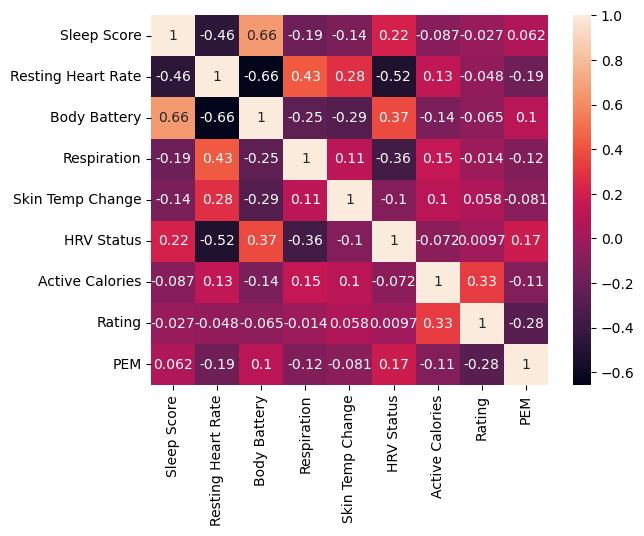

In [17]:
dfp = df.to_pandas()
matrix = dfp.iloc[:, 1:10].corr()
sns.heatmap(matrix, annot=True)

# Check average to get sense of meaningfully close predictions
print(f"Mean rating: {np.mean(dfp.iloc[:, 8])}")
print(f"Standard deviation of rating: {np.std(dfp.iloc[:, 8])}")

## Despite some collinearity, no variables appear duplicative.
## The low correlations between the outcomes and any other variable, including other outcomes,
    ## portend ill for the analysis' success.

Standardize and split data

In [18]:
scaler = StandardScaler()
dfp.iloc[:, 1:7] = scaler.fit_transform(dfp.iloc[:, 1:7])

# Initial split between train, validation, and test sets
## Prioritizing training due to small dataset
dfp_train, dfp_test = train_test_split(dfp.iloc[:, 1:], test_size=0.3, random_state=seed)
dfp_test, dfp_val = train_test_split(dfp_test, test_size=0.5, random_state=seed)
X_train = dfp_train.iloc[:, 0:6]
y_train = dfp_train.iloc[:, 9:]
X_val = dfp_val.iloc[:, 0:6]
y_val = dfp_val.iloc[:, 9:]
X_test = dfp_test.iloc[:, 0:6]
y_test = dfp_test.iloc[:, 9:]

Create ordinal classification model


In [24]:
## Each hyperparameter, including the number of layers and nodes, whether to use L2 regularization on each layer, 
## the batch size, the dropout rate, the learning rate, and the L2 penalty was determined through a manual grid search.

keras.utils.set_random_seed(seed)
input_shape = (6,)

# Set hyperparamters
batch = 32  
nodes = 26  
drop_rate = 0.5  
learn = 0.002  
pen = 0.01 

model = keras.Sequential(
    [ keras.layers.Input(shape = input_shape),
        keras.layers.Dense(nodes, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer1"),
        keras.layers.Dropout(drop_rate, name = "dropout1"),
        keras.layers.Dense(nodes, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer2"),
        keras.layers.Dropout(drop_rate, name = "dropout2"),
        keras.layers.Dense(nodes, activation="relu",  
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer3"),
        # keras.layers.Dense(1, activation = "linear", 
        #                    kernel_regularizer=keras.regularizers.L2(l2=pen), 
        #                    kernel_initializer = keras.initializers.HeNormal(), 
        #                    name = "output")]
        keras.layers.Dense(classes - 1, activation='sigmoid')]
                           )
# model.summary()  # Uncomment to print architecture on screen

model.compile(
    # loss=keras.losses.MeanSquaredError(),
    # optimizer=keras.optimizers.Adam(learning_rate=learn),
    # metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=100, 
                                           restore_best_weights=True)]

results = model.fit(
    X_train, 
    y_train, 
    validation_data = (X_val, y_val), 
    epochs = 1000, 
    verbose = 1,
    callbacks=callbacks,
    batch_size = batch)

print(f'Best validation accuracy: {round(max(results.history['val_accuracy']), 3)}')

test_metrics = model.evaluate(X_test, y_test, return_dict = True, verbose = 0)
print(f'Test accuracy: {round(test_metrics['accuracy'], 3)}')

model.save("final_model_rating_classification.keras")  # save final model
model_final = keras.saving.load_model("final_model_rating_classification.keras")  # reload
predictions = model_final.predict(X_test, verbose = 0) # make predictions

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0271 - loss: 1.4271 - val_accuracy: 0.0500 - val_loss: 0.9525
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0882 - loss: 1.2325 - val_accuracy: 0.1250 - val_loss: 0.8760
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0774 - loss: 1.1417 - val_accuracy: 0.1750 - val_loss: 0.8139
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1425 - loss: 1.1142 - val_accuracy: 0.3000 - val_loss: 0.7624
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1694 - loss: 0.9634 - val_accuracy: 0.3500 - val_loss: 0.7169
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2365 - loss: 0.9408 - val_accuracy: 0.3750 - val_loss: 0.6788
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2940 - loss: 0.8228 - val_accuracy: 0.4000 - val_loss: 0.6473
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2201 - loss: 0.7864 - val_accuracy: 0.5000 - v

Plot training and validation loss and metric

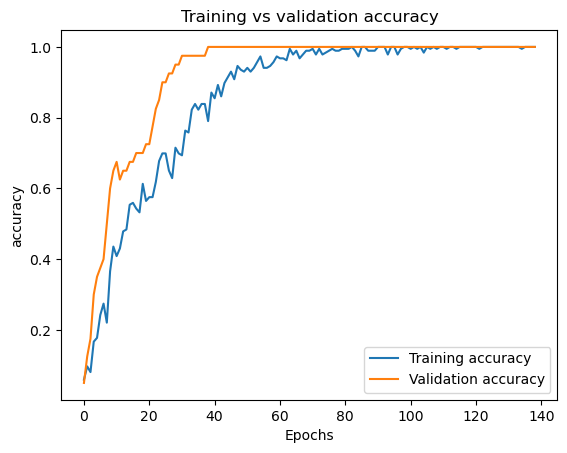

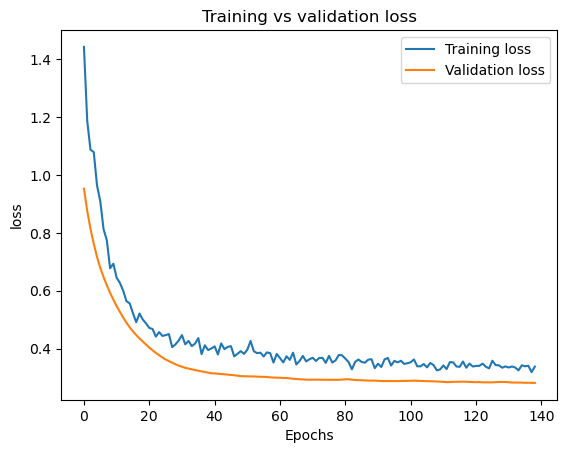

In [22]:
## Oddly, the validation metric and loss are consistently better than the training results: definitely not overfitting!
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Training vs validation {metric}')
    plt.legend()
    plt.show()

# Plot accuracy
plot_metrics(results, 'accuracy')

# Plot loss
plot_metrics(results, 'loss')

Checking correlation of predictions to actual results, using test set 

In [23]:
# Correlation and standard deviation of the errors
print(f'Correlation between observations and predictions: {round(np.corrcoef(y_test, predictions.flatten())[1][0], 2)}') 
print(f'Standard deviation of MAE: {round(np.std(np.absolute(np.subtract(y_test, predictions.flatten()))), 2)}')

# Plotting lowess and linear regression lines, with 95% confidence interval for latter
sns.regplot(y = y_test, x = predictions)
plt.title('Predicted vs Observed Daily Rating')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.xlim(1, 5)
plt.ylim(1,5)
plt.show()

sns.regplot(y = y_test, x = predictions, lowess = True)
plt.title('Predicted vs Observed Daily Rating')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.xlim(1, 5)
plt.ylim(1,5)
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 160

**Discussion:** This discussion is based on the test set (n=40), which makes the conclusions conservative. The lowest (i.e. best) MAE on the validation set was 